# Cloudless and Topographic-Corrected Landsat Composite #

This script purpose is to generate cloudless/cloudmased and also topograhic corrected Landsat data based on certain region of interest and date fully using Python environment.

Landsat data used here is from [Microsoft Planetary Computer STAC / Azure Blob](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/). For now, it can be easily accessed but in future it probably need an account or even paid.

Cloud masking method are based on [Landsat QA PIXEL band](https://www.usgs.gov/landsat-missions/landsat-collection-2-quality-assessment-bands) and topographic correction is based on [SCS+C](https://ieeexplore.ieee.org/document/1499030) method

This script is tailored for [Landsat 8 and 9 Collection 2 Level 2 (Surface Reflectance)](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2), if you want to use it for other multispectral satellite data, you need to modify a lot.

In [2]:
import pystac_client
import json
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import skimage as ski
import planetary_computer
import rasterio as rio
import numpy as np
from skimage.exposure import rescale_intensity
from rasterio.enums import Resampling
from rasterio.merge import merge
import rasterio.windows as windows
import rasterio.transform as transform

### Reading Region of Interest ###

The region of interest (ROI) can be from shapefile, geojson, kml, etc.. that can be read by GeoPandas

This ROI other than to filter the images available also to limit the analysis scope so that it does not have to download the whole scene instead only the one intersect with the ROI.

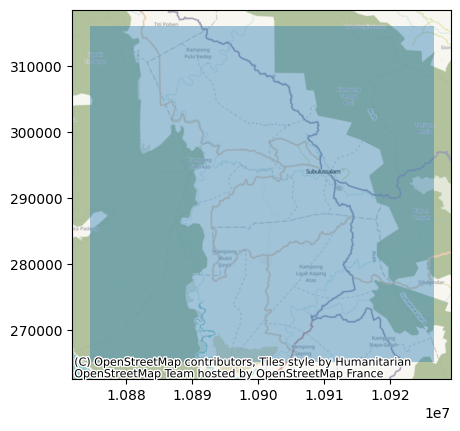

In [3]:
# Load the shapefile
roi = gpd.read_file('roi/example_roi_north_sumatera.shp')

# Plot it
ax = roi.to_crs(epsg=3857).plot(alpha=0.4)
cx.add_basemap(ax)

### Reading STAC ###

In a STAC can be many sources of data. On this script, we will only using the Landsat Collection 2 Level 2.

Other collection is also available if you want to do analysis for other things.

In [ ]:
# Load stac address
stac = json.load(open('../../data/stac.json'))
link = stac['mpc']

# Load STAC
client = pystac_client.Client.open(link, modifier=planetary_computer.sign_inplace)

# Get liss of all collection
collections = [x for x in client.get_collections()]
collections

[<CollectionClient id=daymet-annual-pr>,
 <CollectionClient id=daymet-daily-hi>,
 <CollectionClient id=3dep-seamless>,
 <CollectionClient id=3dep-lidar-dsm>,
 <CollectionClient id=fia>,
 <CollectionClient id=sentinel-1-rtc>,
 <CollectionClient id=gridmet>,
 <CollectionClient id=daymet-annual-na>,
 <CollectionClient id=daymet-monthly-na>,
 <CollectionClient id=daymet-annual-hi>,
 <CollectionClient id=daymet-monthly-hi>,
 <CollectionClient id=daymet-monthly-pr>,
 <CollectionClient id=gnatsgo-tables>,
 <CollectionClient id=hgb>,
 <CollectionClient id=cop-dem-glo-30>,
 <CollectionClient id=cop-dem-glo-90>,
 <CollectionClient id=goes-cmi>,
 <CollectionClient id=terraclimate>,
 <CollectionClient id=nasa-nex-gddp-cmip6>,
 <CollectionClient id=gpm-imerg-hhr>,
 <CollectionClient id=gnatsgo-rasters>,
 <CollectionClient id=3dep-lidar-hag>,
 <CollectionClient id=io-lulc-annual-v02>,
 <CollectionClient id=conus404>,
 <CollectionClient id=3dep-lidar-intensity>,
 <CollectionClient id=3dep-lidar-point

### Filtering Images in the Collection ###

Using our ROI and time interval we can filter the collection that only fullfill this filter.

This filtered collection will have the information needed to load the image (including qa pixel) and the metadata topographic correction

In [ ]:
# Parameter for search
# BBOX or boundary
bbox = roi.bounds.iloc[0]

# Look for certain ranges of date
# Use 4 months between 2024 may to 2024 august
start = '2024-05'
end = '2024-08'

# Use the landsat collection 2 level surface reflectance
# Filter only landsat 8 and 9
# Flter only tier 1 data (the good one)
search = client.search(
	collections=['landsat-c2-l2'],
	bbox=bbox,
	datetime=f'{start}/{end}',
	filter={
		"op": "and",
		"args": [
			{ "op": "or", "args": [
				{ "op": "=", "args": [ { "property": "platform" }, "landsat-8"] },
				{ "op": "=", "args": [ { "property": "platform" }, "landsat-9"] }
			] },
			{ "op": "=" , "args": [ { "property": "landsat:collection_category" }, "T1" ] }
		]
	}
)

# List of data
data_list = [x for x in search.items_as_dicts()]
print(f'Images count: {len(data_list)}')
data_list[0:1]

Images count: 28


[{'id': 'LC08_L2SP_129058_20240824_02_T1',
  'bbox': [97.23099518368116,
   1.8392043483551892,
   99.28208506435773,
   3.941035651644811],
  'type': 'Feature',
  'links': [{'rel': 'collection',
    'type': 'application/json',
    'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2'},
   {'rel': 'parent',
    'type': 'application/json',
    'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2'},
   {'rel': 'root',
    'type': 'application/json',
    'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/'},
   {'rel': 'self',
    'type': 'application/geo+json',
    'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2/items/LC08_L2SP_129058_20240824_02_T1'},
   {'rel': 'cite-as',
    'href': 'https://doi.org/10.5066/P9OGBGM6',
    'title': 'Landsat 8-9 OLI/TIRS Collection 2 Level-2'},
   {'rel': 'via',
    'href': 'https://landsatlook.usgs.gov/stac-server/collections/landsat-c2l

### Preview of the filtered images ####

From all the filtered images, we can preview using the already rendered JPEG image from the collection. By previewing we can check if the filter is correct.

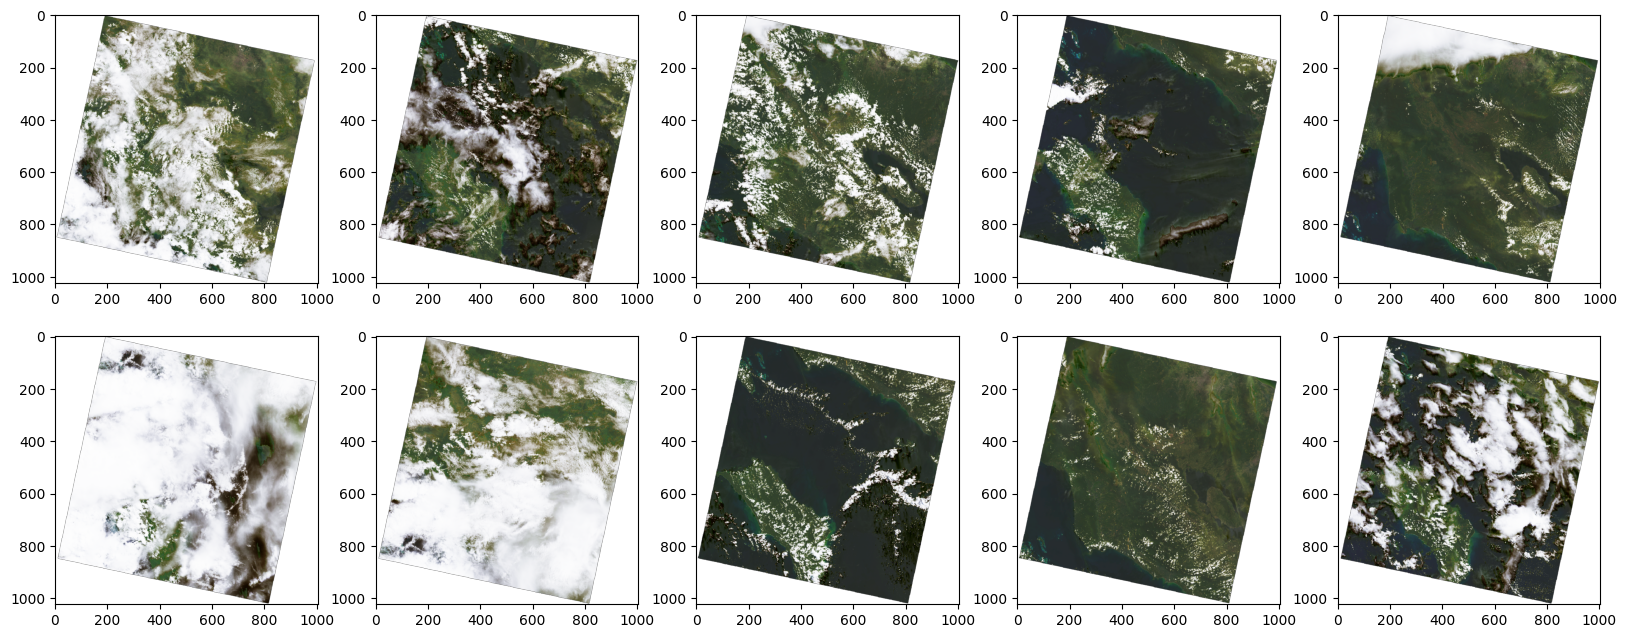

In [5]:
# Plot thumbnail every images
plt.figure(figsize=(20, 16))

# Load as plot
# Only the first 10
for x in range(0, len(data_list)):
	if (x < 10):
		dict = data_list[x]
		thumbnail = dict['assets']['rendered_preview']['href']
		image = ski.io.imread(thumbnail)
		plt.subplot(4, 5, x + 1)
		plt.imshow(image)

### Load Images + Cloud Masking ###

From all the filtered images in the collection, we will loop it where we will load only the image bands needed

We will also load the qa pixel band where it contain the information needed to create clear mask to mask the image

The cloud masked image then will be put into a list where it will become a multi dimensional array that can be aggregated to get a cloudless median composite

C:\Users\ramiq\AppData\Local\Temp\ipykernel_28648\2471845345.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window = windows.from_bounds(bbox_small[0], bbox_small[1], bbox_small[2], bbox_small[3], qband_transform)


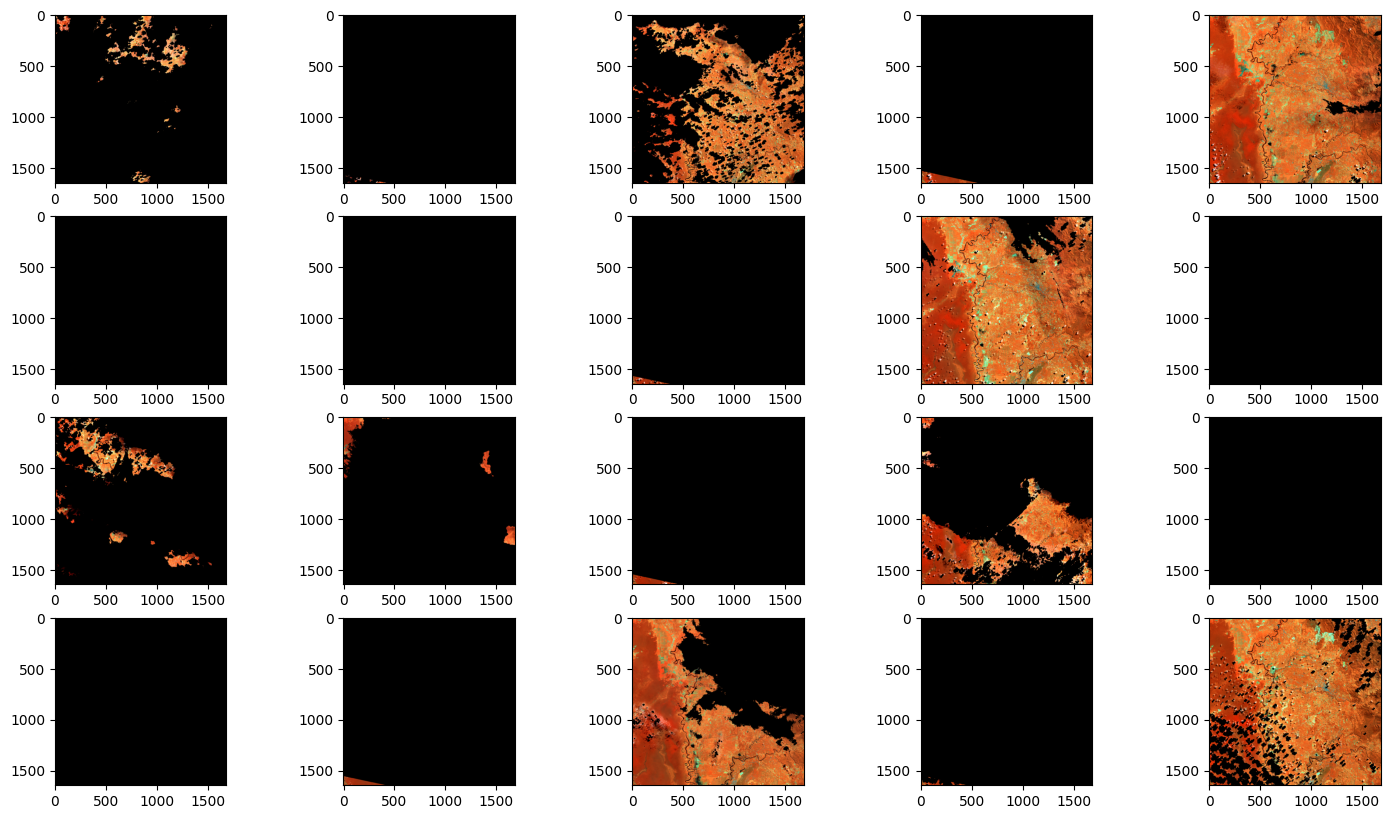

In [8]:
# Load the tif images
plt.figure(figsize=(18, 10))

# Select the bands needed
bands = ['coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22']
qband = 'qa_pixel'

# Load bands
cloud_masked_images = []
for x in range(0, len(data_list)):
	# Get dict of data in the items
	assets = data_list[x]['assets']

	# Get the quality band
	qband_source = rio.open(assets[qband]['href'])

	# Make window to read file only on specific part
	# Using our ROI BBOX to limit read
	qband_transform = qband_source.transform

	# Create a bbox based on the CRS of the image
	bbox_small = roi.to_crs(qband_source.crs).bounds.iloc[0]

	# Window to read the imagew
	window = windows.from_bounds(bbox_small[0], bbox_small[1], bbox_small[2], bbox_small[3], qband_transform)

	# Qband raster
	qband_image = qband_source.read(1, window=window, boundless=True, fill_value=1, out_shape=(dem_shape[0], dem_shape[1]))

	# Make cloud mask
	cloud_mask = (qband_image != 1) & ((qband_image & (1 << 1)) == 0) & ((qband_image & (1 << 2)) == 0) & ((qband_image & (1 << 3)) == 0) & ((qband_image & (1 << 4)) == 0)

	# Cloud masked image
	# Load source each band
	sources = [rio.open(assets[y]['href']) for y in bands]

	# Make into 1 stack
	stack = np.stack([source.read(1, window=window, boundless=True, fill_value=-9999, out_shape=(dem_shape[0], dem_shape[1])) for source in sources]) * 0.0000275 + -0.2

	# Apply cloud mask per band
	for y in range(0, len(stack)):
		stack[y][cloud_mask == 0] = -9999

	# Add each image to the list of images
	cloud_masked_images.append(stack)

	# Make composite using NIR SWIR1 SWIR2
	# Only 20 bands
	if (x < 20):
		# Make range into 0 - 1
		out_range = (0, 1)
		composite = np.dstack([
			rescale_intensity(stack[4], in_range=(0.1, 0.4), out_range=out_range),
			rescale_intensity(stack[5], in_range=(0.05, 0.3), out_range=out_range),
			rescale_intensity(stack[6], in_range=(0.025, 0.25), out_range=out_range),
		])

		# Plot
		plt.subplot(4, 5, x + 1)
		plt.imshow(composite)

# Make list of images as numpy stack
cloud_masked_images = np.stack(cloud_masked_images)

### Load DEM ###

DEM (Digital Elevation Model) is important to do topographic correction.

The DEM used for this script is the NASADEM which also come from MPC STAC.

In [6]:
# Search DEM data
dem_data_search = client.search(
	collections=['nasadem'],
	bbox=bbox
)

# Load DEM as rio
dem_sources = [rio.open(x['assets']['elevation']['href']) for x in dem_data_search.items_as_dicts()]

# Merge DEM
merge_dem, dem_transform = merge(dem_sources, bounds=(bbox[0], bbox[1], bbox[2], bbox[3]))
merge_dem = merge_dem[0]

# DEM shape
dem_shape = merge_dem.shape

C:\Users\ramiq\AppData\Local\Temp\ipykernel_28648\2582099654.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merge_dem, dem_transform = merge(dem_sources, bounds=(bbox[0], bbox[1], bbox[2], bbox[3]))


### Generate Slope and Aspect ###

DEM data can be derived into slope and aspect which can be used as parameter to do topographic correction

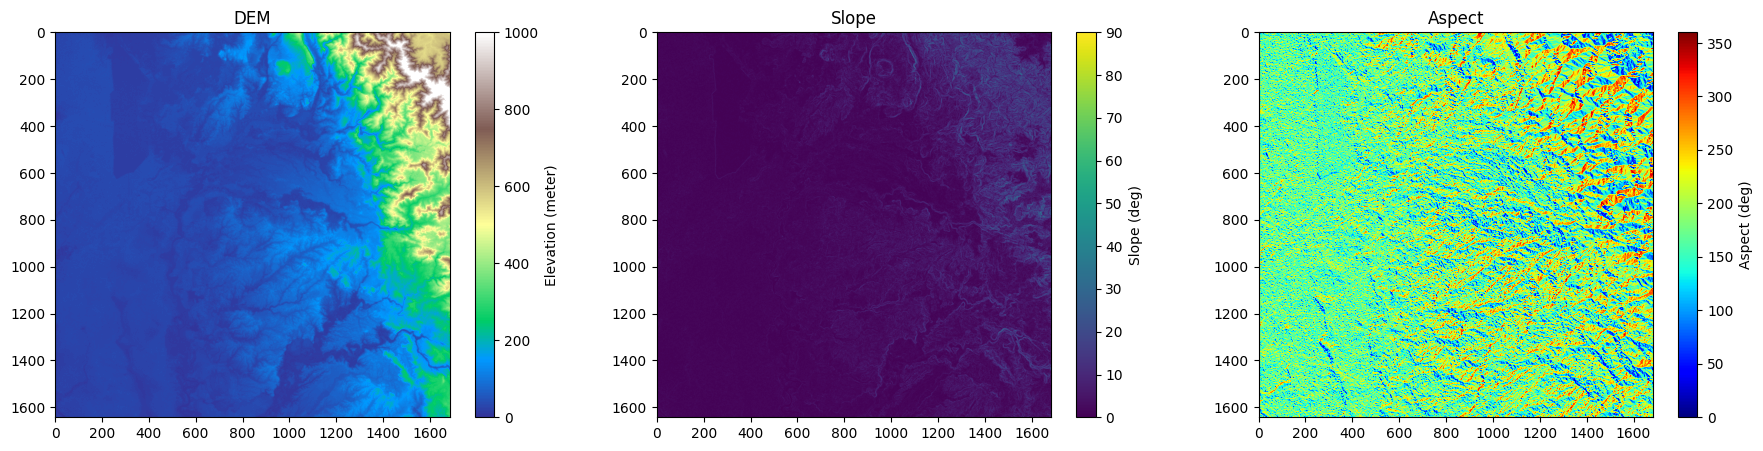

In [7]:
# Plot
plt.figure(figsize=(22, 5))

# Plot DEM
plt.subplot(1, 3, 1)
plt.title('DEM')
plt.imshow(merge_dem, vmin=0, vmax=1000, cmap='terrain')
plt.colorbar(label='Elevation (meter)')

# Pi
pi = 3.14159265359

# Make slope
py, px = np.gradient(merge_dem, 100)
slope = np.sqrt((px ** 2) + (py ** 2))
slope_deg = slope / 1 * 90
slope_rad = slope_deg / 180 * pi
plt.subplot(1, 3, 2)
plt.title('Slope')
plt.imshow(slope_deg, vmin=0, vmax=90)
plt.colorbar(label='Slope (deg)')

# Make aspect
aspect = np.arctan2(py, -px)
aspect_normalized = np.degrees(aspect)
aspect_normalized = (aspect_normalized + 360) % 360
aspect_rad = aspect_normalized / 180 * pi

plt.subplot(1, 3, 3)
plt.title('Aspect')
plt.imshow(aspect_normalized, vmin=0, vmax=360, cmap='jet')
plt.colorbar(label='Aspect (deg)')

### Apply Topographic Correction ####

Using the formula for SCS+C, the already cloud masked images then will be used as regression with incidence angle (generated using SCS+C method).

Only the images that have slope above 5 degree, incidence angle more than 0, and clear image (not cloud masked) will be applied topographic correction.

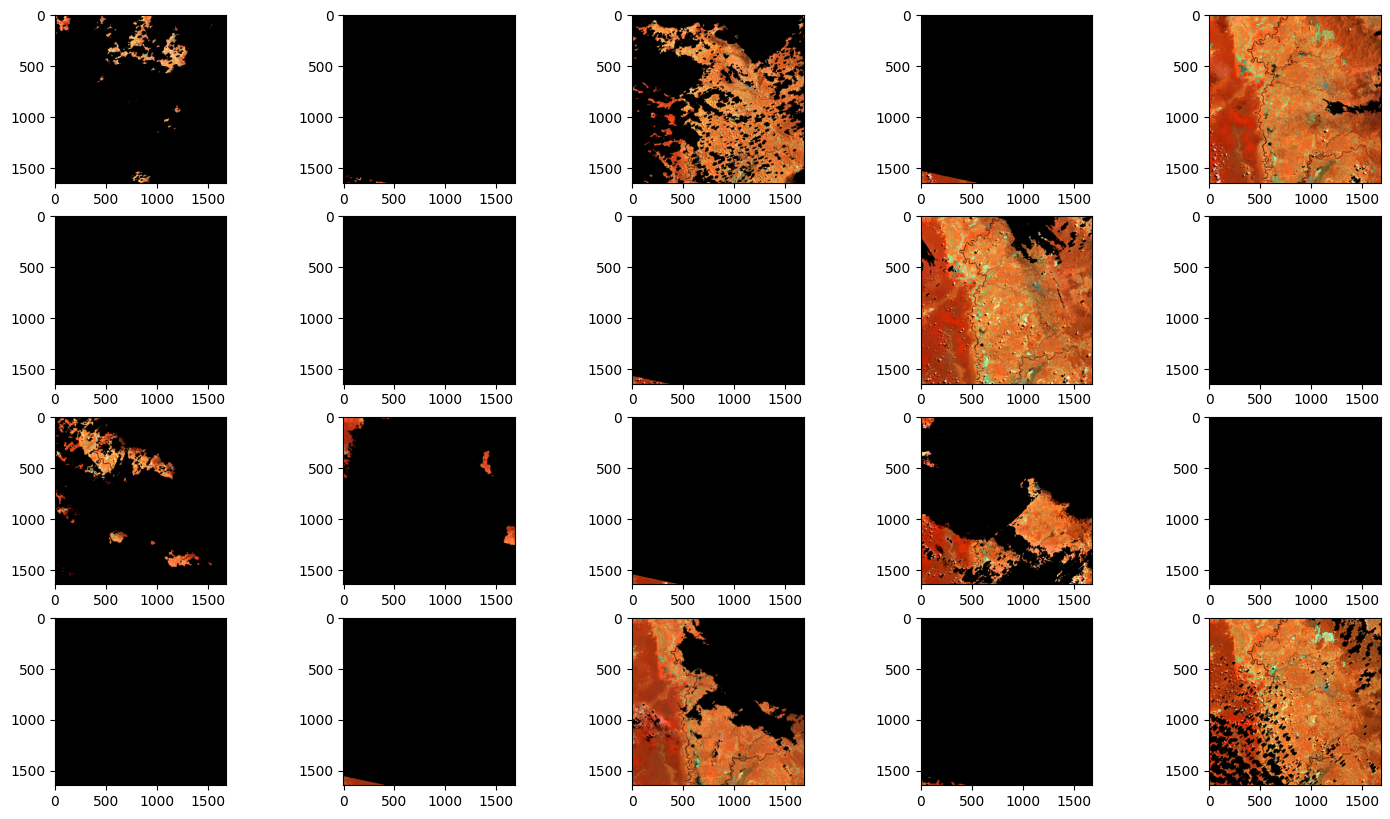

In [9]:
# Topographic corrected
plt.figure(figsize=(18, 10))
cloud_topo_images = []
for x in range(0, len(data_list)):
	# Read asset properties
	properties = data_list[x]['properties']

	# Get the angle parameter for topographic correction
	azimuth_rad = properties['view:sun_azimuth'] * pi / 180
	elevation = properties['view:sun_elevation']
	zenith_rad = (elevation - 90) * pi / 180

	# Another parameter for topographic correction
	cos_zenith = np.cos(zenith_rad)
	cos_slope = np.cos(slope_rad)
	slope_illumination = cos_zenith * cos_slope
	sin_zenith = np.sin(zenith_rad)
	sin_slope = np.sin(slope_rad)
	cos_azmiuth_dif = np.cos(azimuth_rad - aspect_rad)
	aspect_illumination = sin_zenith * sin_slope * cos_azmiuth_dif
	incidence_angle = slope_illumination + aspect_illumination

	# Copy of cloud masked image
	copy_image = cloud_masked_images[x].copy()

	# Mask to do topographic correction
	mask_topo = (slope_deg >= 5) & (incidence_angle >= 0) & (copy_image[4] >= 0)
	mask_topo_1d = mask_topo.reshape(-1)

	# Incidence angle in 1 dimension
	ic_1d = incidence_angle.reshape(-1)[mask_topo_1d]

	# Do regression per band with incidence angle
	for y in range(0, len(copy_image)):
		# Get both only useful array
		image_band_1d = copy_image[y].reshape(-1)[mask_topo_1d]

		# If there is a valid data, do the regression
		if (len(image_band_1d) & len(ic_1d)):
			# Get the scale and offset of
			scale, offset = np.polyfit(ic_1d, image_band_1d, 1)

			# C data
			c = offset / scale

			# Apply topographic correction only to masked area
			copy_image[y] = np.where(mask_topo == 1, copy_image[y] * (cos_slope * cos_zenith + c) / (incidence_angle + c), copy_image[y])

	# Make composite using NIR SWIR1 SWIR2
	# Only 20 bands
	if (x < 20):
		# Make range into 0 - 1
		out_range = (0, 1)
		composite = np.dstack([
			rescale_intensity(copy_image[4], in_range=(0.1, 0.4), out_range=out_range),
			rescale_intensity(copy_image[5], in_range=(0.05, 0.3), out_range=out_range),
			rescale_intensity(copy_image[6], in_range=(0.025, 0.25), out_range=out_range),
		])

		# Plot
		plt.subplot(4, 5, x + 1)
		plt.imshow(composite)

	# Add each image to the list of images
	cloud_topo_images.append(copy_image)

cloud_topo_images = np.stack(cloud_topo_images)

### Median Cloudless and Topographic Landsat Composite ###

From the stack of only cloudless images and cloudless + topographic corrected, a median aggregation is done on the first dimension where from 28 images returning in 1 image.

Here we visualize the difference in a plot of both images.

C:\Users\ramiq\AppData\Local\Temp\ipykernel_28648\3526935362.py:7: RuntimeWarning: All-NaN slice encountered
  cloud_masked_median = np.nanmedian(cloud_masked_images_ma, 0)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_28648\3526935362.py:25: RuntimeWarning: All-NaN slice encountered
  cloud_topo_median = np.nanmedian(cloud_topo_images_ma, 0)


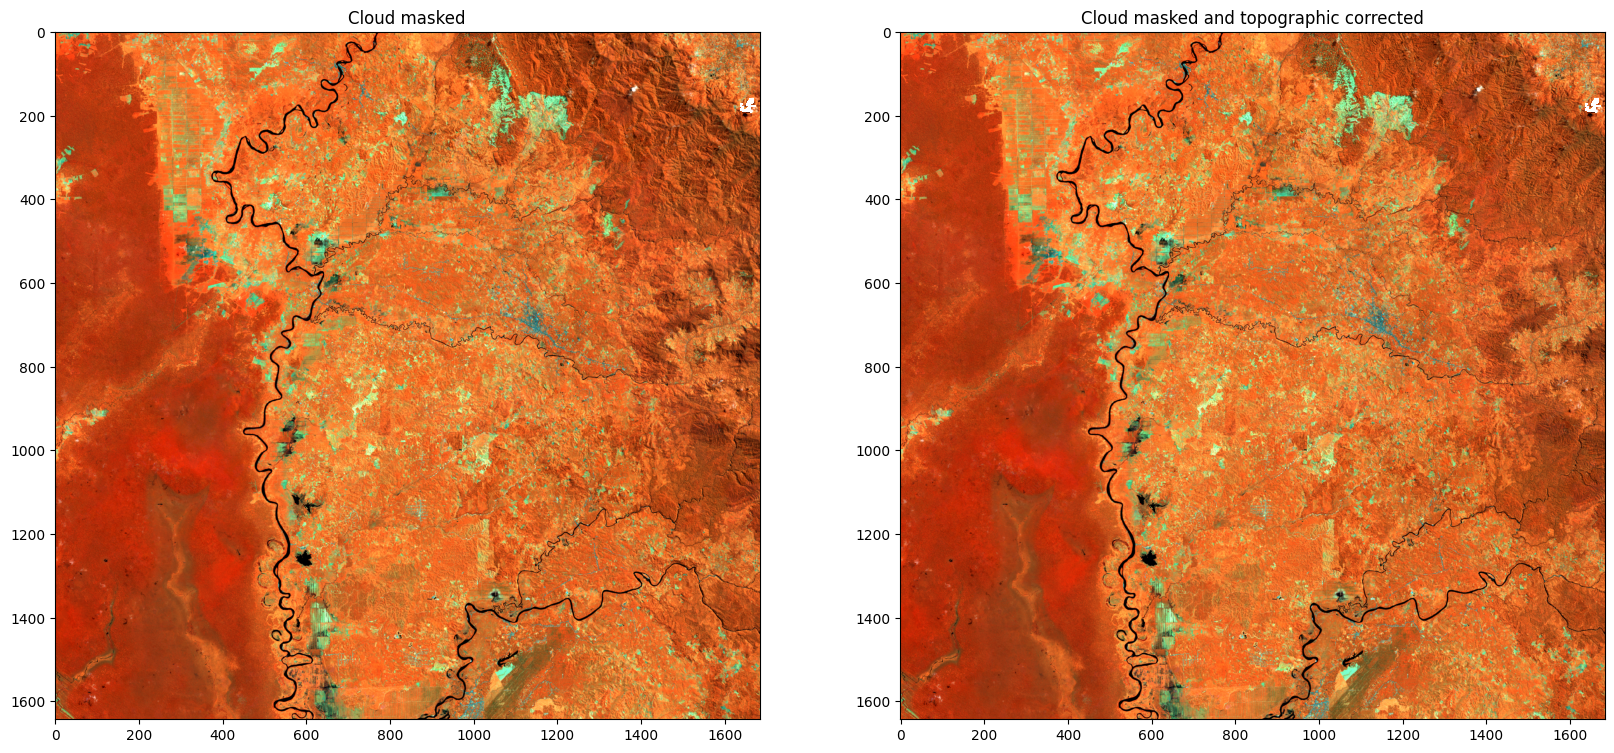

In [10]:
plt.figure(figsize=(20, 10))

## Cloud masked ##

# Median composite along its 0 axis
cloud_masked_images_ma = np.ma.masked_where(cloud_masked_images < 0, cloud_masked_images)
cloud_masked_median = np.nanmedian(cloud_masked_images_ma, 0)

# Composite median for visualization
composite = np.dstack([
	rescale_intensity(cloud_masked_median[4], in_range=(0.1, 0.4), out_range=(0, 1)),
	rescale_intensity(cloud_masked_median[5], in_range=(0.05, 0.3), out_range=(0, 1)),
	rescale_intensity(cloud_masked_median[6], in_range=(0.025, 0.25), out_range=(0, 1))
])

plt.subplot(1, 2, 1)
plt.title('Cloud masked')
plt.imshow(composite)


## Topographic Corrected ##

# Median composite along its 0 axis
cloud_topo_images_ma = np.ma.masked_where(cloud_topo_images < 0, cloud_topo_images)
cloud_topo_median = np.nanmedian(cloud_topo_images_ma, 0)

# Composite median for visualization
composite = np.dstack([
	rescale_intensity(cloud_topo_median[4], in_range=(0.1, 0.4), out_range=(0, 1)),
	rescale_intensity(cloud_topo_median[5], in_range=(0.05, 0.3), out_range=(0, 1)),
	rescale_intensity(cloud_topo_median[6], in_range=(0.025, 0.25), out_range=(0, 1))
])

plt.subplot(1, 2, 2)
plt.title('Cloud masked and topographic corrected')
plt.imshow(composite)

### Save the Image ###

If the result is satisfactory then saved it to the local storage

In [ ]:
# Save image as geotiff
int_image_cloudless = cloud_masked_median * 1e4
int_image_cloudless[cloud_masked_median < 0] = -9999
output = rio.open(
	'result/cloudless_landsat_composite.tif',
	'w',
	'COG',
	count=int_image_cloudless.shape[0],
	width=int_image_cloudless.shape[2],
	height=int_image_cloudless.shape[1],
	crs=roi.crs,
	transform=transform.from_bounds(*bbox, width=int_image_cloudless.shape[2], height=int_image_cloudless.shape[1]),
	nodata=-9999,
	dtype='uint16',
	compress='lzw',
	resampling=Resampling.bilinear
)
output.write(int_image_cloudless)
output.descriptions = tuple(['COASTAL', 'BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2'])
output.close()

# Save image as geotiff
int_image_top = cloud_topo_median * 1e4
int_image_top[cloud_topo_median < 0] = -9999
output = rio.open(
	'result/cloudless_topocorrect_landsat_composite.tif',
	'w',
	'COG',
	count=cloud_topo_median.shape[0],
	width=cloud_topo_median.shape[2],
	height=cloud_topo_median.shape[1],
	crs=roi.crs,
	transform=transform.from_bounds(*bbox, width=cloud_topo_median.shape[2], height=cloud_topo_median.shape[1]),
	nodata=-9999,
	dtype='uint16',
	compress='lzw',
	resampling=Resampling.bilinear
)
output.write(int_image_top)
output.descriptions = tuple(['COASTAL', 'BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2'])
output.close()